# WMT of tendency terms
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)

# 1) Make histogram of each term <a class='anchor' id='first-bullet'> </a>
(use logarithmic scale on y-axis)

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import gcsfs
from xhistogram.xarray import histogram

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [4]:
import json
with open('/home/jovyan/chapter2/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

tendencies = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tendencies.zarr')).drop(['nlon', 'nlat'])
tendencies

<xarray.Dataset>
Dimensions:    (time: 182, nlat: 2400, nlon: 3600)
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [18]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [19]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.21bc82f44e864abda0cdedb2f9423278/status,


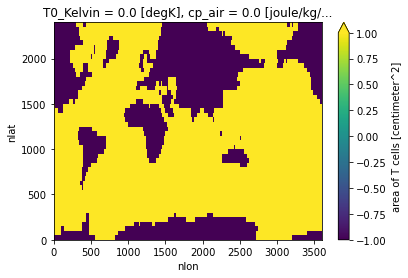

In [59]:
ds.TAREA.plot(vmin=-1, vmax=1)

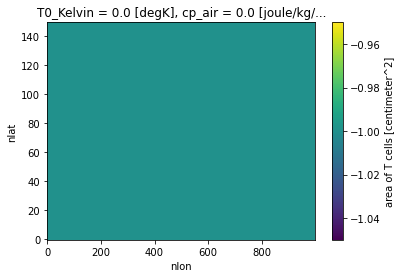

In [58]:
ds.TAREA.isel(nlon=slice(1000, 2000), nlat=slice(0,150)).plot()

In [10]:
rho = xr.apply_ufunc(jmd95numba.rho, ds.SSS, ds.SST, 0,
                        output_dtypes=[ds.SST.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load())

In [14]:
rho = rho.isel(time=slice(0,182))

In [5]:
vol = ds.TAREA * ds.dz
delta_rho = 0.01
rho_bins = np.arange(1015, 1030, delta_rho)

In [6]:
tendency_terms = xr.merge([(tendencies.SST_bih*tendencies.drhodt).rename('sst'), 
                           (tendencies.SSS_bih*tendencies.drhods).rename('sss'), 
                            tendencies.rho_bih.rename('rho'), 
                            tendencies.cabbeling.rename('cabbeling')])

In [7]:
all_tendencies = list(tendency_terms)

In [8]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=variable.fillna(0.), dim=['nlon', 'nlat'])
    return hist / delta_rho

In [16]:
histograms = xr.merge([histogram_func(tendency_terms[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])

In [38]:
histograms

<xarray.Dataset>
Dimensions:          (time: 182, rho0_bin: 1499)
Coordinates:
  * time             (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
Data variables:
    OMEGA_sst        (time, rho0_bin) float32 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float32 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_rho        (time, rho0_bin) float32 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_cabbeling  (time, rho0_bin) float32 dask.array<chunksize=(1, 1499), meta=np.ndarray>

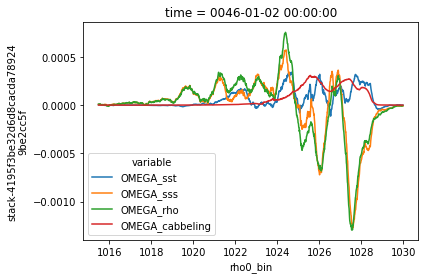

In [44]:
histograms.isel(time=0).to_array().rolling(rho0_bin=50).mean().plot.line(hue='variable');

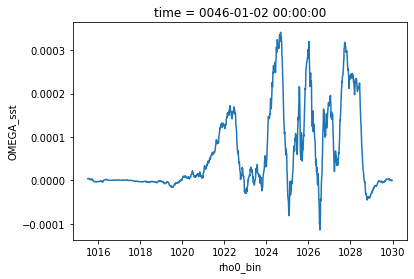

In [45]:
histograms.isel(time=0).OMEGA_sst.rolling(rho0_bin=50).mean().plot();

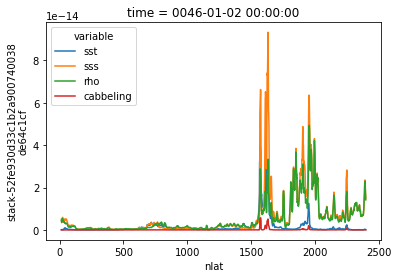

In [48]:
#Magnify the significant values by squaring to see if temp plays a bigger role than what we've seen in the above figs
(tendency_terms.isel(time=0)**2).mean('nlon').to_array().rolling(nlat=10).mean().plot.line(hue='variable');

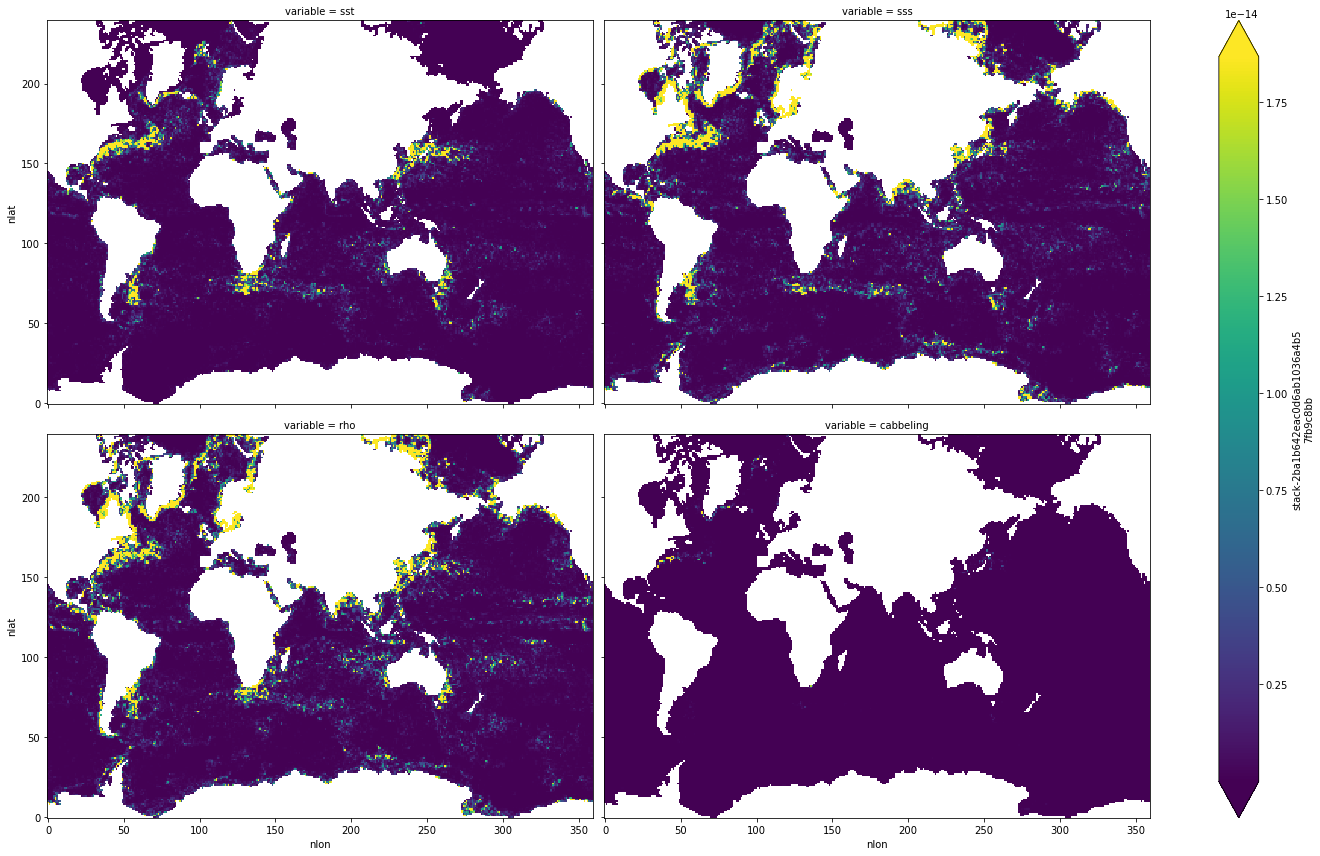

In [49]:
(tendency_terms.isel(time=0)**2).coarsen(nlon=10, 
                                         nlat=10).mean().to_array().plot(col='variable', 
                                                                         col_wrap=2, robust=True, 
                                                                         figsize=(20, 12))

[Back to top](#top)

In [2]:
import json
with open('/home/jovyan/chapter2/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
tendencies = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tendencies.zarr')).drop(['nlon', 'nlat'])
tendencies

<xarray.Dataset>
Dimensions:    (time: 182, nlat: 2400, nlon: 3600)
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds_unsliced  = cat["CESM_POP_hires_control"].to_dask()
ds = ds_unsliced.isel(time=slice(0,182))# slicing to just first 6mo (to match tendencies ds)

In [64]:
def horizontal_turner_angle():
    """Compute horizontal turner angle given SST and SSS"""
    
    #create grad-rho / |grad-rho| term
    rho = jmd95numba.rho(ds.SSS, ds.SST, 0)
    gradρ_modgradρ = tendencies.rho_bih / np.absolute(tendencies.rho_bih)
    
    #define alpha and beta
    runit2mass = 1.035e3 #rho_0
    alpha = - tendencies.drhodt / runit2mass
    beta = tendencies.drhods / runit2mass
    
    #create temperature and salinity components of equation
    temp_comp = alpha*tendencies.SST_bih
    salt_comp = beta*tendencies.SSS_bih
    
    #define eq
    turner_angle = np.arctan2(xr.dot(gradρ_modgradρ, (temp_comp+salt_comp)), xr.dot(gradρ_modgradρ, (temp_comp-salt_comp)))
    
    return turner_angle

In [87]:
horizontal_turner_angle().values

array(nan, dtype=float32)

In [ ]:
#create grad-rho / |grad-rho| term
rho = jmd95numba.rho(ds.SSS, ds.SST, 0)
gradρ_modgradρ = tendencies.rho_bih / np.absolute(tendencies.rho_bih)
    
#define alpha and beta
runit2mass = 1.035e3 #rho_0
alpha = - tendencies.drhodt / runit2mass
beta = tendencies.drhods / runit2mass
    
#create temperature and salinity components of equation
temp_comp = alpha*tendencies.SST_bih
salt_comp = beta*tendencies.SSS_bih
    
#define eq (w/o grad-rho / |grad-rho| term
turner_angle = np.arctan2((temp_comp+salt_comp), (temp_comp-salt_comp))

In [7]:
selection = dict(time=10, nlat=slice(1550,1650), nlon=slice(300,500))

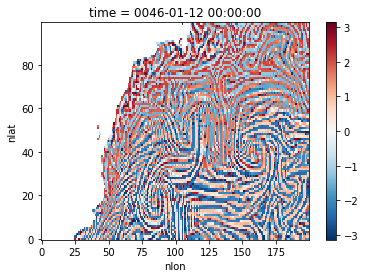

In [9]:
turner_angle.isel(**selection).plot()

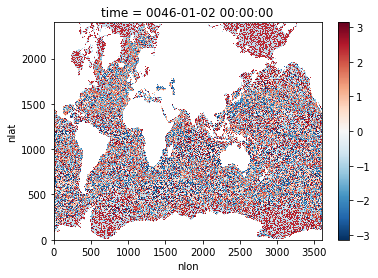

In [13]:
turner_angle[0].plot()

In [16]:
turner_angle[0,1600,600].values

array(-1.2946212, dtype=float32)

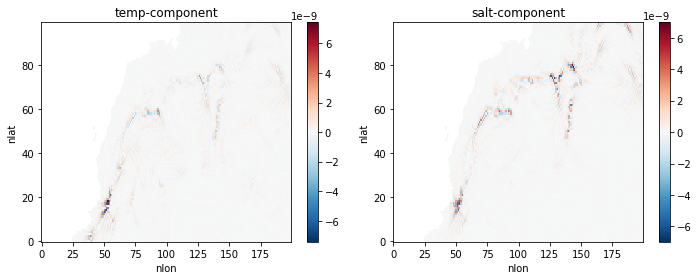

In [99]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(10,4))

temp_comp.isel(**selection).plot(ax=ax0)
salt_comp.isel(**selection).plot(ax=ax1)
ax0.set_title('temp-component')
ax1.set_title('salt-component')
plt.tight_layout();

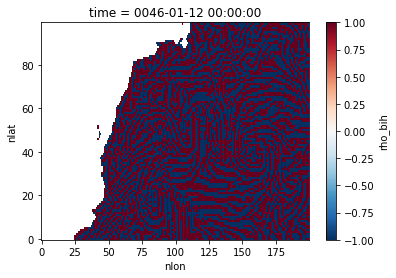

In [100]:
gradρ_modgradρ.isel(**selection).plot()

In [102]:
xr.dot(gradρ_modgradρ, (temp_comp+salt_comp)).values

array(nan, dtype=float32)

[Back to top](#top)